# Graph Tool Sanbox

In [2]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
import json
from glob import glob
from tqdm import tqdm
import random

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


Grafo Minimo reproducible similar al grafo grande

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5)]
This are our toy weights [8, 9, 7, 10, 12, 11]


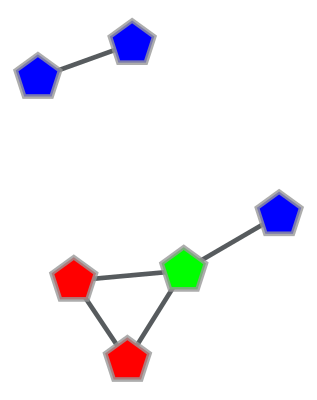

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe9a13fe210, at 0x7fe9a14b0dd0>

In [106]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5)] # ,(5,4) vovler a colocarlo
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11]
g = gt.Graph(directed=False)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")
edge_date_map = g.new_edge_property('string')

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]
    edge_date_map[e] = '2021-05-16'

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.ep['Normal Weights'] = edge_weight_map
g.ep['Ending date'] = edge_date_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

Filtrar el grafo en función de alguna propidad categorica del nodo. en este caso el espéctro político

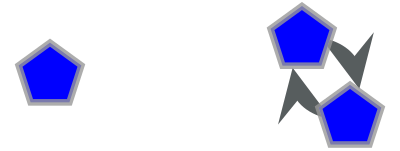

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe9a14ed690, at 0x7fe9a215c050>

In [41]:
# FILTERING A GRAPH BASED ON VERTEX PROPERTY
def filter_graph(g:gt.Graph, type:str) -> gt.Graph:
    # Filter edges connected to nodes labeled type
    filtered_edges = g.new_edge_property("bool")
    filtered_edges.a = False

    # Filter nodes with label type
    filtered_nodes = g.new_vertex_property("bool")
    filtered_nodes.a = False

    for v in g.vertices():
        if g.vertex_properties['Political Label'][v] == type:
            filtered_nodes[v] = True
            for edge in v.out_edges():
                if g.vertex_properties['Political Label'][edge.target()] == type:
                    filtered_edges[edge] = True

    # Generate the subgraph using the filtered nodes and edges
    subgraph = gt.GraphView(g, vfilt=filtered_nodes, efilt=filtered_edges)
    
    return subgraph

subgraph = filter_graph(g,'i')

gt.graph_draw(subgraph,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [107]:
def get_adjacency(g : gt.Graph, weight = None) -> np.ndarray:
    # Get EdgePropertyMap for Weights in Adjacency
    if weight is not None:
        weights = g.ep[weight]
    else: weights = weight

    adj = gt.adjacency(g, weight = weights).T
    return adj.toarray()

def get_types_array(g: gt.Graph, types = None) -> np.ndarray:
    t = g.vp[types].get_2d_array([0])[0]
    return t

def get_types_dict(g: gt.Graph, types = None) -> dict:
    # Get array of types
    t = get_types_array(g,types)
    T = {}
    for tipo in np.unique(t):
        row=[]
        for i in t:
            if i == tipo:
                row.append(1)
            else:
                row.append(0)        
        T[str(tipo)] = row
    return T

def get_types_index(g: gt.Graph, types = None) -> dict:
    T = get_types_dict(g, types)
    Type_to_row = {k:v for v,k in enumerate(T.keys())}
    return Type_to_row

def get_types_matrix(g: gt.Graph, types = None) -> np.ndarray:
    types_dict = get_types_dict(g,types = types)
    types_vector = types_dict.values()
    return np.array(list(types_vector)).T

def get_contact_layer(g, types = None, weights = None) -> np.ndarray:
    adj = get_adjacency(g, weights)
    types_matrix = get_types_matrix(g, types = types)
    M = types_matrix.T.dot(adj).dot(types_matrix)
    if g.is_directed():
        return M
    else: 
        M_undir = np.copy(M)
        M_undir[np.tril_indices(M.shape[0], k=-1)] = 0
        np.fill_diagonal(M_undir, M_undir.diagonal() / 2)
        return M_undir

def me_vs_others(M: np.array, group_index: int) -> np.array:
    M_11 = M[group_index, group_index]
    M_12 = np.sum(M[group_index,:]) - M_11
    M_21 = np.sum(M[:, group_index]) - M_11
    not_me_contact = np.delete(np.delete(M, group_index, axis=0), group_index, axis=1)
    M_22 = np.sum(not_me_contact)
    
    me_vs_others = np.array([[M_11, M_12],[M_21,M_22]])
    
    return me_vs_others

In [90]:
# FUNCTION TESTING
print('Adjacency Matrix')
print(get_adjacency(g,weight='Normal Weights'))
print('Nodes')
print(g.get_vertices())
print('Types Array')
print(get_types_array(g,types='Political Label'))
print('Types Dictionary')
print(get_types_dict(g,types='Political Label'))
print('Types Index Dictionary')
print(get_types_index(g,types='Political Label'))
print('Types Matrix (A column is one of the arrays in the Types Dictionary)')
print(get_types_matrix(g,types='Political Label'))
print('Contact Layer')
print(get_contact_layer(g,types='Political Label'))
print('Me Vs Others (Contact Layer cosidering one group Against all others) for Derecha')
print(me_vs_others(get_contact_layer(g,types='Political Label'), get_types_index(g,types='Political Label')['d'] ))

Adjacency Matrix
[[ 0.  8.  7.  0.  0.  0.]
 [ 8.  0.  9. 10.  0.  0.]
 [ 7.  9.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  0. 12.  0.]]
Nodes
[0 1 2 3 4 5]
Types Array
['d' 'i' 'd' 'i' 'i' 'i']
Types Dictionary
{'d': [1, 0, 1, 0, 0, 0], 'i': [0, 1, 0, 1, 1, 1]}
Types Index Dictionary
{'d': 0, 'i': 1}
Types Matrix (A column is one of the arrays in the Types Dictionary)
[[1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]
Contact Layer
[[1. 2.]
 [0. 2.]]
Me Vs Others (Contact Layer cosidering one group Against all others) for Derecha
[[1. 2.]
 [0. 2.]]


In [112]:
def Freeman_Global_No_Weight(g: gt.Graph, types = None) -> float:
    """
    Global freeman Segregation Index

    Args:
        g (Graph): The Graph object to analize.
        
        types (String): The name of the PropertyMap where the tipification of the nodes groups resides.

    Returns:
        type: Segregation Index of Freeman

    """
    # Get Relevant Matrices
    types_matrix = get_types_matrix(g, types = types)
    M = get_contact_layer(g, types = types)
    
    # We get the amount of vertices and groups
    N, K = types_matrix.shape
    # Get the amount of nodes per group
    n_k =[]
    for k in range(K):
        n = np.sum(types_matrix[:, k])
        n_k.append(n)
    n_k = np.array(n_k)
    print(n_k)
    print(get_types_index(g,'Political Label'))
    
    # Calculate In-Between edges
    M_up = np.triu(M,k=1)
    M_low = np.tril(M,k=1)
    between_edges = M_up.sum() + M_low.sum()

    # Calculate P 
    P = between_edges / M.sum()

    # Prepare for calculation
    numerator = P * N * (N - 1)
    denominator = (n_k.sum() **2) - (np.sum(n_k **2))

    # calculate using the formula
    S = 1 - (numerator / denominator)
    
    return S

Freeman_Global_No_Weight(g, types = 'Political Label')

[1 2 3]
{'c': 0, 'd': 1, 'i': 2}


0.18181818181818177

In [105]:
def Freeman_Groups_No_Weight(g: gt.Graph, types:str, group:str) -> float:
    """
    Description of your function.

    Args:
        g (Graph): The Graph object to analize.
        
        types (String): The name of the PropertyMap where the tipification of the nodes groups resides.

        groups (String): The name of the group To calculate the Segregation Index

    Returns:
        type: Segregation Index of Freeman from one group against all the other groups

    """
    # get important stuff
    M = get_contact_layer(g, types=types)
    groups = get_types_index(g,types)
    groups_list = get_types_dict(g,types=types)[group]
    group_index = groups[group]
    
    # Calculate contact Matrix, me vs others
    me_vs_others_matrix = me_vs_others(M, group_index)
    
    # Getting group sizes
    total = g.num_vertices()
    nodes_in_group = sum(groups_list)
    nodes_out_group = g.num_vertices() - nodes_in_group
    
    # Calculating P (Proportion of Between group edges)
    P = me_vs_others_matrix[0,1] / np.sum(me_vs_others_matrix)
    
    # Calculating Pi (Expected Proportion of Between-group ties in random graph)
    Pi = (2 * nodes_in_group * nodes_out_group) / (total * (total - 1))
    
    return (Pi-P)/Pi

Freeman_Groups_No_Weight(g, types='Political Label', group = 'd')

0.24999999999999994

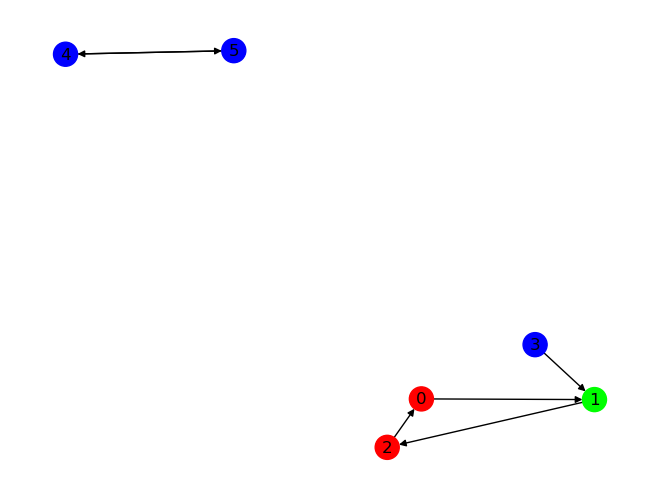

In [26]:
def to_networkx(g: gt.Graph) -> nx.Graph:
    
    if g.is_directed():
        nx_graph = nx.DiGraph()
    else:
        nx_graph = nx.Graph()

    # Add nodes with their properties to the NetworkX graph
    for v in g.vertices():
        node_properties = {prop_name: g.vp[prop_name][v] for prop_name in g.vp}
        nx_graph.add_node(int(v), **node_properties)

    # Add edges with their properties to the NetworkX graph
    for e in g.edges():
        edge_properties = {prop_name: g.ep[prop_name][e] for prop_name in g.ep}
        nx_graph.add_edge(int(e.source()), int(e.target()), **edge_properties)
    
    return nx_graph

g_nx = to_networkx(g)
colors = [node[1]['Color'] for node in g_nx.nodes(data=True)]
pos = nx.spring_layout(g_nx) 
nx.draw(g_nx, pos,node_color=colors, with_labels=True)